In [80]:
import pandas as pd
import mols2grid
from ChemBERT_module2 import combinatorial_synthesis
from drugGen_generator import run_inference
import plotly.figure_factory as ff
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import torch
from torch_geometric.utils import from_smiles
from torch_geometric.loader import DataLoader
from torch_geometric.nn.models import AttentiveFP

from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski, Crippen
from rdkit.Chem.QED import default as qed_calc
from rdkit.Contrib.SA_Score import sascorer

In [81]:
def run_llm1(smiles, iterations=100, temperature=1.0, max_new_tokens=20, prefix='t1'):
    l1, l2 = combinatorial_synthesis(smiles=smiles, iterations=iterations, temperature=temperature, max_new_tokens=max_new_tokens)
    list_of_ids_non_seq = [f'{prefix}Non_seq_{id}' for id in range(len(l2))]
    dict_non_seq = {'id': list_of_ids_non_seq, 'smiles': l2, 'mols': l1}
    df_non_seq = pd.DataFrame(dict_non_seq)

    return df_non_seq

In [82]:
def run_llm2(sequence: list, num_generated: int=100, output_file="output_SMILES.txt"):
    run_inference(sequences=sequence, num_generated=num_generated, output_file=output_file)
    with open(output_file, 'r') as file:
        content = file.read()
    
    content_as_list = content.split("'")
    content_as_list = [content_as_list[l] for l in range(len(content_as_list)) if l%2 != 0]

    list_of_ids_seq = [f'Seq_{id}' for id in range(len(content_as_list))]
    dict_seq = {'id': list_of_ids_seq, 'smiles': content_as_list}
    df_seq = pd.DataFrame(dict_seq)
    df_seq['mols'] = df_seq['smiles'].apply(lambda mol: Chem.MolFromSmiles(mol))

    return df_seq

In [83]:
sequence = 'MEECWVTEIANGSKDGLDSNPMKDYMILSGPQKTAVAVLCTLLGLLSALENVAVLYLILSSHQLRRKPSYLFIGSLAGADFLASVVFACSFVNFHVFHGVDSKAVFLLKIGSVTMTFTASVGSLLLTAIDRYLCLRYPPSYKALLTRGRALVTLGIMWVLSALVSYLPLMGWTCCPRPCSELFPLIPNDYLLSWLLFIAFLFSGIIYTYGHVLWKAHQHVASLSGHQDRQVPGMARMRLDVRLAKTLGLVLAVLLICWFPVLALMAHSLATTLSDQVKKAFAFCSMLCLINSMVNPVIYALRSGEIRSSAHHCLAHWKKCVRGLGSEAKEEAPRSSVTETEADGKITPWPDSRDLDLSDC'

df_non_seq1 = run_llm1(smiles='C', max_new_tokens=50, iterations=100, temperature=0.2, prefix='t02_C_')
df_non_seq2 = run_llm1(smiles='C', max_new_tokens=50, iterations=100, temperature=0.7, prefix='t07_C_')
df_non_seq3 = run_llm1(smiles='C', max_new_tokens=50, iterations=100, temperature=1.2, prefix='t1_2_C_')

df_seq = run_llm2(sequence=[sequence], num_generated=100)

Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
2026-01-26 23:34:46,072 - INFO - Loading model and tokenizer: alimotahharynia/DrugGen
2026-01-26 23:34:49,883 - INFO - Moving model to CUDA device.
2026-01-26 23:34:55,121 - INFO - Starting SMILES generation process...
2026-01-26 23:34:55,124 - INFO - Generating SMILES for sequence: MEECWVTEIA...
2026-01-26 23:35:31,528 - INFO - SMILES generation for sequence completed. Generated 104 SMILES.
2026-01-26 23:35:31,531 - INFO - Completed SMILES generation for 1 entries.


Generated SMILES saved to output_SMILES.txt


In [84]:
df = pd.concat([df_seq, df_non_seq1, df_non_seq2, df_non_seq3])
df = df.dropna(subset='mols')

print(f'DF shape before deduplication: {df.shape}')
df = df.drop_duplicates(subset = ['smiles'])
print(f'DF shape after deduplication: {df.shape}')

DF shape before deduplication: (373, 3)
DF shape after deduplication: (344, 3)


In [85]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = AttentiveFP(in_channels=9, hidden_channels=96, out_channels=1, edge_dim=3, num_layers=6, num_timesteps=3, dropout=0.042543)
state_dict = torch.load("attentivefp_model_final_full_data.pth", map_location=device)

model.load_state_dict(state_dict)
model.to(device)
model.eval()

AttentiveFP(in_channels=9, hidden_channels=96, out_channels=1, edge_dim=3, num_layers=6, num_timesteps=3)

In [86]:
def make_graphs(dataframe):
    graphs_list = []
    for sm in dataframe["smiles"]:
        g = from_smiles(sm)
        g.x = g.x.float()
        graphs_list.append(g)

    return graphs_list

In [87]:
graphs_list = make_graphs(df)
loader = DataLoader(graphs_list, batch_size=64, shuffle=False)

In [88]:
@torch.no_grad()
def predict_affinity(model, loader):
    preds = []
    model.eval()
    for data in loader:
        data = data.to(device)
        out = model(data.x, data.edge_index, data.edge_attr, data.batch)
        preds.append(out.cpu())
    
    predictions = torch.cat(preds).numpy()
    return predictions

In [89]:
predictions = predict_affinity(model, loader)

In [90]:
df['Predicted_pKi'] = predictions
df = df.dropna(subset = ['mols'])
df['QED'] = df['mols'].apply(lambda x: qed_calc(x))
df['synthetic_accesibility'] = df['mols'].apply(lambda mol: sascorer.calculateScore(mol))

In [91]:
df1 = df[df['id'].str.startswith('t02_C_')]
df2 = df[df['id'].str.startswith('t07_C_')]
df3 = df[df['id'].str.startswith('t1_2_C_')]
df4 = df[df['id'].str.startswith('Seq')]

In [92]:
df[['LLM configuration']] = df['id'].str.extract(r'(.*)_Non_seq_.*')
df.fillna('Seq', inplace=True)

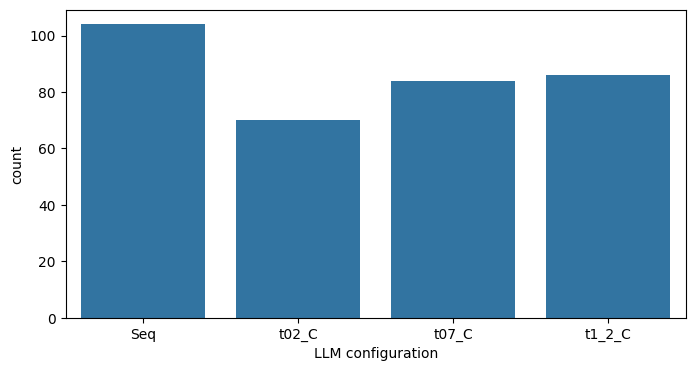

In [93]:
df = df.reset_index(drop=True)
plt.figure(figsize=(8, 4))
sns.countplot(data=df, x='LLM configuration')
plt.show()

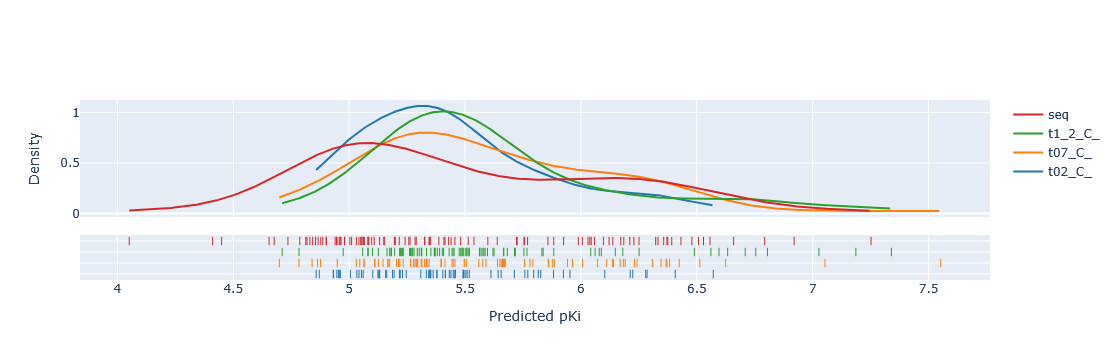

In [97]:
hist_data = [df1['Predicted_pKi'], df2['Predicted_pKi'], df3['Predicted_pKi'], df4['Predicted_pKi'] ]
group_labels = ['t02_C_', 't07_C_', 't1_2_C_', 'seq']

fig = ff.create_distplot(hist_data, group_labels, bin_size=.2, show_hist=False)
fig.update_layout(xaxis_title='Predicted pKi', yaxis_title='Density')
fig.show()

In [95]:
df['MW'] = df['mols'].apply(lambda x: Descriptors.ExactMolWt(x))
df['FCsp3'] = df['mols'].apply(lambda x: Lipinski.FractionCSP3(x))
df['HBA'] = df['mols'].apply(lambda x: Lipinski.NumHAcceptors(x))
df['HBD'] = df['mols'].apply(lambda x: Lipinski.NumHDonors(x))
df['Rotatable_bonds'] = df['mols'].apply(lambda x: Lipinski.NumRotatableBonds(x))
df['RingCount'] = df['mols'].apply(lambda x: Lipinski.RingCount(x))
df['TPSA'] = df['mols'].apply(lambda x: Descriptors.TPSA(x))
df['LogP'] = df['mols'].apply(lambda x: Crippen.MolLogP(x))

In [96]:
mols2grid.display(df, smiles_col='smiles')